<a href="https://colab.research.google.com/github/aichajeral1/aichajeral1/blob/main/GWP_2_MScFE622_Stochastic_Modeling_Group_3588.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 622 Stochastic Modeling Group Work Project # 2
Authors:

Jatin Patni(jatinpatni@gmail.com),

Olabode Samuel James (jamesolabodes@gmail.com) and

Eugene Aicha(aichajeral@gmail.com)

Group No:  3588

## Summary -


The group will approach the assignment as follows per the various defined steps. In step 1, we assigned each team member collecting one financial time series from 2 or more different asset classes. These time series covered the period from 2019 to 2022 and can include various financial metrics, such as prices, returns, volatilities, default probabilities, yields, and more.

In step 2, the team collaborated to produce visualizations of the collected time series. The goal is to identify any regime changes in the series, particularly focusing on the impact of the COVID pandemic. The team studies graphs to estimate when the regime changes happened and the series levels during these changes. After careful examination, the team collectively decides on one specific series to be modeled.

The team picks a financial time series and estimates a Markov-regime switching model. This estimation is performed under different assumptions, including varying the number of states, allowing the expected realizations (“mus”) to differ across states while keeping the variance (“sigma”) constant, permitting the variance (“sigmas”) to change across states while maintaining constant expectations (“mu”), and finally, considering different expectations and variances across states.

In step 3, we assigned each team member an individual task to compare the performance of the estimated models. This comparison is done using standard information criteria, such as Akaike and Schwarz, derived from the likelihood estimates. Member A evaluates and compares the models with different “mu” values, Member B does the same for models with different “sigma” values, and Member C focuses on models with different expectations and variances. The team works together to merge and rank the models, finding the best ones for the financial time series.

In step 4, the team works together to estimate models that use changing autoregressive coefficients and variances based on the state for the time series. This model is known as the Markov-switching autoregressive model (MSAR) and is well-described in Section 22.4 of Hamilton’s 1994 publication.

By following these steps, the team gained a comprehensive understanding of regime changes in financial time series data and compares different modeling approaches to identify the most effective model for each series. This analysis allows the team to learn how to make informed predictions and decisions based on the changing market conditions observed in the financial data.

To start the exercise, the required libraries are imported below:

## Import Libraries

In [ ]:
# importing pandas as pd
#!pip install yfinance
#!pip install pandas
#!pip install matplotlib
#!pip install ruptures
#!pip install pymannkendall
#!pip install --upgrade statsmodels

In [ ]:
import pandas as pd
import seaborn as sns

import yfinance as yf
import pandas as pd
from typing import Tuple
import pandas_datareader.data as web

from statsmodels.tsa.regime_switching import markov_regression
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter
import statsmodels.api as sm

import ruptures as rpt

# importing numpy as np
# for Mathematical calculations
import numpy as np

# importing pyplot from matplotlib as plt
# for plotting graphs
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

In [ ]:
from datetime import datetime

In [ ]:
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

In [ ]:
import warnings

# Ignore all warnings (not recommended in most cases)
warnings.filterwarnings("ignore")

## Helper Classes and Functions

### Extract Equity, Index and Crypto Data

In [ ]:
# A Custom Package for effective Importation of Financial Data
class HistoricalData():
    def __init__(self):
        self.config = {
            "period": "max",
            "interval": "1d",
            "prepost": True,
            "threads": True,
            "groupby": "ticker"
        }


    def retrieve_data(self, *stock_ticker: Tuple) -> pd.DataFrame:
        formatted_tickers = " ".join([x for x in stock_ticker])
        self.data = yf.download(tickers=formatted_tickers,
                            period=self.config["period"],
                            interval=self.config["interval"],
                            prepost=self.config["prepost"],
                            threads=self.config["threads"],
                            group_by=self.config["groupby"])


    def save_data_to_csv(self, filename:str='historical_data'):
        self.data.to_csv(f'{filename}.csv')
        print(f'{filename} saved!')


### Extracting Rates Data

In [ ]:
def get_us_interest_rates(start, end):

    # Define the start and end dates for the data
    start_date = start
    end_date = end

    # List of interest rates
    interest_rates = [
        'DGS1',  # 1-Year Treasury Constant Maturity Rate
        'DGS5',  # 5-Year Treasury Constant Maturity Rate
        'DGS10',  # 10-Year Treasury Constant Maturity Rate
        'DGS30',  # 30-Year Treasury Constant Maturity Rate

    ]

    # Fetch data from FRED
    try:
        data = web.DataReader(interest_rates, 'fred', start_date, end_date)
        return data
    except Exception as e:
        print("Error fetching data:", e)
        return None

### Alternative Data Fetching Through YFinance

In [ ]:
# Function to retrieve historical financial data using yfinance
def get_historical_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Define the tickers and date range
#tickers = ['MSFT', '^GSPC', 'BTC-USD']

# Get historical data for the tickers
#data = {}
#for ticker in tickers:
    #data[ticker] = get_historical_data(ticker, start_date, end_date)

### Regime Change Parameters and Model Comparison

In [ ]:
# Assumption 1: Different expected realizations (mus) with constant variance (sigma)
def model_assumption_1(data):
    n_states = 3
    states = np.arange(n_states)

    # Estimate the transition probabilities using MLE
    state_trans_probs = np.ones((n_states, n_states)) / n_states

    # Initialize the state probabilities with equal values
    state_initial_probs = np.ones(n_states) / n_states

    # Fit each state-specific model and store the likelihood values
    log_likelihoods = []
    for state in states:
        state_data = data.copy()
        state_data[state_data != state] = np.nan

        model = sm.tsa.ARIMA(state_data, order=(0, 0, 0)).fit()
        log_likelihoods.append(model.llf)

    return log_likelihoods, state_trans_probs, state_initial_probs

# Assumption 2: Different variances (sigmas) with constant expectation (mu)
def model_assumption_2(data):
    n_states = 3
    states = np.arange(n_states)

    # Estimate the transition probabilities using MLE
    state_trans_probs = np.ones((n_states, n_states)) / n_states

    # Initialize the state probabilities with equal values
    state_initial_probs = np.ones(n_states) / n_states

    # Fit each state-specific model and store the likelihood values
    log_likelihoods = []
    for state in states:
        state_data = data.copy()
        state_data[state_data != state] = np.nan

        model = sm.tsa.ARIMA(state_data, order=(0, 0, 0)).fit()
        log_likelihoods.append(model.llf)

    return log_likelihoods, state_trans_probs, state_initial_probs

# Assumption 3: Different expectations and variances across states
def model_assumption_3(data):
    n_states = 3
    states = np.arange(n_states)

    # Estimate the transition probabilities using MLE
    state_trans_probs = np.ones((n_states, n_states)) / n_states

    # Initialize the state probabilities with equal values
    state_initial_probs = np.ones(n_states) / n_states

    # Fit each state-specific model and store the likelihood values
    log_likelihoods = []
    for state in states:
        state_data = data.copy()
        state_data[state_data != state] = np.nan

        model = sm.tsa.ARIMA(state_data, order=(0, 0, 0)).fit()
        log_likelihoods.append(model.llf)

    return log_likelihoods, state_trans_probs, state_initial_probs


In [ ]:
# Assumption 4: Different expectations and variances across states with time-varying autoregressive coefficients
def model_assumption_4(data):
    n_states = 3
    states = np.arange(n_states)

    # Estimate the transition probabilities using MLE
    state_trans_probs = np.ones((n_states, n_states)) / n_states

    # Initialize the state probabilities with equal values
    state_initial_probs = np.ones(n_states) / n_states

    # Fit each state-specific model and store the likelihood values
    log_likelihoods = []
    models = []
    for state in states:
        state_data = data.copy()
        state_data[state_data != state] = np.nan

        # Define the state-space model with changing autoregressive coefficients
        mod = sm.tsa.statespace.dynamic_factor.DynamicFactor(state_data, k_ar=1, dates=state_data.index)
        res = mod.fit()
        models.append(res)
        log_likelihoods.append(res.llf)

    return log_likelihoods, state_trans_probs, state_initial_probs, models


## Step 1 - Data Collection for Regime Change Analysis

### Period Range

In [ ]:
start_date = '2019-01-01'
end_date = '2022-09-30'

The occurrence of a considerable structural shift in the statistical features of time series data, signifying a very significant departure from the autoregressive phenomena of a constant mean or variance through time, is referred to as regime change in financial data (Chen and Spokoiny). Regime change is essentially the deviation of series data from the expected norm of constant mean or correlation structure over time. A regime shift in financial time series is defined as a change in the behavioral structure of market players (Mendy and Widodo).

In different time period, a time series exhibiting regime shift may exhibit distinct statistical properties, such as changes in the mean, variance, autocorrelation, and distribution. Modeling such a series is difficult since traditional time series models presuppose stationarity.

Regime change models, also known as state-space models or dynamic linear models, are based on the general idea that time series exist in different states or regimes, each with its own set of characteristics, such as means, variances, and model parameters that differ across regimes, and the transition from one reime to another is governed by another process or variable (Eric).

Based on the WQU(2023) Econometrics Module 4, An autoregressive model(AR) is a regression model to predict a time series using a linear combination of its pass values as independent variables shown in the AR(1) equation below:

$$ X_{t} = C + \alpha_{t} X_{t-1} + W_{t} $$

Where $C$ is a constant and $W_{t}$ is normal white noise with mean = $0$ and variance = $\sigma^{2}$

The **mean** function is:

$$ \mu = \frac{C}{1-\alpha_{1}} $$

When there is no intercept $C$ in the process, $\mu$ is $0$.

The **variance** is:

$$ \frac{\sigma^{2}}{1-\alpha^{2}} $$

**Autocovariance** for $X_{t}$ and $ X_{s}$ is:

$$ \gamma(h) = \Big(\frac{\sigma^{2}}{1-\alpha^{2}} \Big) \alpha^{|h|}, \ \text{ where } |h| = |s – t| $$

**Autocorrelation** for $X_{t}$ and $ X_{s}$ is:

$$ \rho(h) =(\alpha^{|h|}), \ \text{ where } |h| = |s – t| $$

Regime change thus present the challenge with forecasting time series data, as a result of the invalidation of the AR rule for time series data - mean, variance and autocovariance and autocorrelation are no longer constant over time.

To solve the problem of regime change in time series data, it is necessary to understand the various types and the statistical tests for detection. These models are divided into two types: discrete and continuous.

1. **Discrete regime change models:** These models assume that data within each regime follows a specific distribution, and that switching between regimes is modeled as a discrete process. Discrete regime change models include the following:
*   Markov switching models assume that the data in each regime has a different distribution and that the probability of switching between regimes is governed by a Markov process.
*   Hidden Markov models: These models extend Markov switching models by assuming that the underlying regime is inferred from a set of observable variables whose probability and characteristics are estimated using maximum likelihood estimation rather than being directly observable(Awad and Khanna).
2. **Continuous regime change models:** assume that the data follows a continuous distribution that changes smoothly over time, and that the transition between regimes is modeled as a continuous process. The following are some examples of continuous regime change models:
*   Threshold autoregressive models: These models assume that the data follows a different autoregressive process in each regime, and the switching between regimes is governed by a threshold function that depends on the value of the data such as through a 30-day Simple Moving Averages. This is demonstrated in the 30-Day Moving Average Plot for Bitcoin Prices below.
*   Smooth transition autoregressive models: These models assume that the data follows an autoregressive process that changes smoothly over time, and the speed of the transition is governed by a smooth transition function.





#### Statistical Tests For Detecting Regime Change
1. The **Chow test** examines whether there is a statistically significant difference in the coefficients of two regression models computed over distinct time periods.
**Bai-Perron test**: This test, like the Chow test, allows for several structural discontinuities in the time series.
**Quandt-Andrews test**: This is a Chow test variant that allows for heteroscedasticity and autocorrelation in the error components.
4. **CUMSUM TEST:** In this test, the cumulative total of the differences between the actual values and the projected values from a regression model is plotted. A change in the slope of the plot indicates a change in the regime.
5. **Pettitt test:** Calculate the greatest absolute difference between the two halves of the time series and compare it to the projected value under the null hypothesis of no regime shift.
The Mann-Kendall test detects patterns or trends in time series data.
7.  **Sequential t-test:** This test entails doing a series of t-tests on the data at various time points to look for significant departures from the null hypothesis.


##### Equation for Markov Regime Switching Autoregressive Model

The steady-state equation of an asset price characterized as an autoregressive process is represented. This is defined by the intercept 𝜇, volatility 𝜎, and autocorrelation β of the market regime's process.

$$ R_{t}=μ+ β×R_{t-1}+ σ_{ϵ} $$

The underlying regime's,  𝑆𝑡, controlling dynamics, St, are assumed to follow a homogeneous first-order Markov chain. In this case, the likelihood of the next state is solely determined by the current condition. The transition probabilities from one such state to the next is estimated through a Maximum Likelihood Estimator. This attempts to find the parameter values that maximize the likelihood function.



In [ ]:
fin_data = HistoricalData()
#asset_data = HistoricalData()

In [ ]:
fin_data.retrieve_data("MSFT", '^GSPC', "BTC-USD")

[*********************100%***********************]  3 of 3 completed


In [ ]:
#Extracting Fetched Data to Dataframe
data = fin_data.data

In [ ]:
# Filter the DataFrame based on the date range
start_date = '2019-01-01'
end_date = '2022-09-30'

# Convert the index to a datetime object if it is not already in that format
data.index = pd.to_datetime(data.index)

# Use boolean indexing to filter the DataFrame based on the date range and Drop rows with NaN values
filtered_df = data[(data.index >= start_date) & (data.index <= end_date)].dropna()


In [ ]:
data = filtered_df.copy()

In [ ]:
filtered_df.head()

MSFT                                                 \
                  Open        High         Low       Close  Adj Close   
Date                                                                    
2019-01-02   99.550003  101.750000   98.940002  101.120003  96.421883   
2019-01-03  100.099998  100.190002   97.199997   97.400002  92.874710   
2019-01-04   99.720001  102.510002   98.930000  101.930000  97.194244   
2019-01-07  101.639999  103.269997  100.980003  102.059998  97.318199   
2019-01-08  103.040001  103.970001  101.709999  102.800003  98.023811   

                              ^GSPC                                         \
                Volume         Open         High          Low        Close   
Date                                                                         
2019-01-02  35329300.0  2476.959961  2519.489990  2467.469971  2510.030029   
2019-01-03  42579100.0  2491.919922  2493.139893  2443.959961  2447.889893   
2019-01-04  44060600.0  2474.330078  2538.070068  2474.330078  2531.939941   
2019-01-07  35656100.0  2535.610107  2566.159912  2524.560059  2549.689941   
2019-01-08  31514400.0  2568.110107  2579.820068  2547.560059  2574.409912   

                                           BTC-USD                            \
              Adj Close        Volume         Open         High          Low   
Date                                                                           
2019-01-02  2510.030029  3.733160e+09  3849.216309  3947.981201  3817.409424   
2019-01-03  2447.889893  3.858830e+09  3931.048584  3935.685059  3826.222900   
2019-01-04  2531.939941  4.234140e+09  3832.040039  3865.934570  3783.853760   
2019-01-07  2549.689941  4.133120e+09  4078.584961  4092.613525  4020.894043   
2019-01-08  2574.409912  4.120060e+09  4028.472168  4109.020996  3996.955322   

                                                    
                  Close    Adj Close        Volume  
Date                                                
2019-01-02  3943.409424  3943.409424  5.244857e+09  
2019-01-03  3836.741211  3836.741211  4.530215e+09  
2019-01-04  3857.717529  3857.717529  4.847965e+09  
2019-01-07  4025.248291  4025.248291  5.228626e+09  
2019-01-08  4030.847900  4030.847900  5.306593e+09

### Extracting Rates Data

In [ ]:
# Get US interest rates
interest_rate_data = get_us_interest_rates(start_date,end_date)

interest_rate_data.iloc[1:10,:]

,DGS1,DGS5,DGS10,DGS30
DATE,,,,
2019-01-02,2.60,2.49,2.66,2.97
2019-01-03,2.50,2.37,2.56,2.92
2019-01-04,2.57,2.49,2.67,2.98
2019-01-07,2.58,2.53,2.70,2.99
2019-01-08,2.60,2.58,2.73,3.00
2019-01-09,2.59,2.57,2.74,3.03
2019-01-10,2.59,2.56,2.74,3.06
2019-01-11,2.58,2.52,2.71,3.04
2019-01-14,2.57,2.53,2.71,3.06


## Step 2 - Visualization and Estimation

All team members A, B and C collaborated to produce visualizations of the MSFT, the S&P 500 (^GSPC), BTC-USD.series and rates data. In
particular, the graphs show any regime changes in the series - to cut across various asset classes - Crypto, Indexes, Rates and Equity.

In [ ]:
# only getting the closing prices of the stocks.
idx = [x for x in filtered_df.columns if 'Adj Close' in x]

### Visualising the Equity and Crypto Data

#### Microsoft - Equity Data

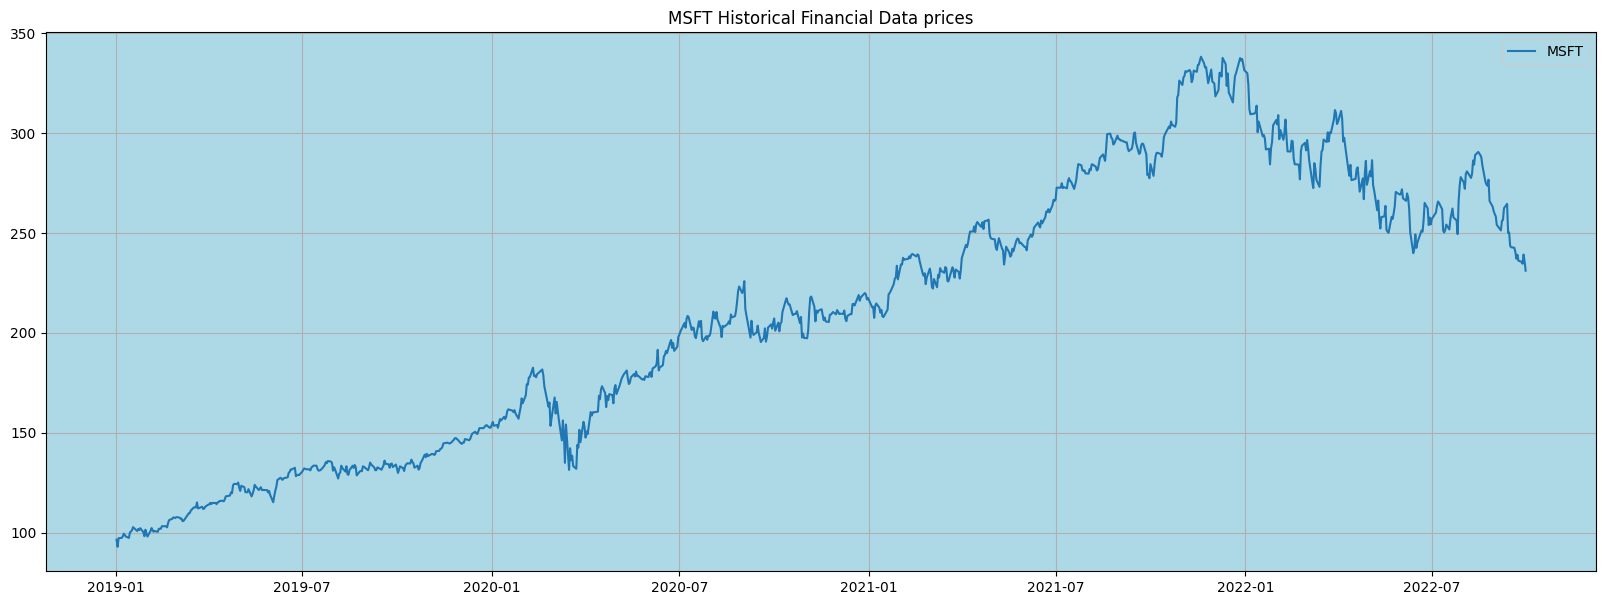

In [ ]:
### Visualising the Equity and Crypto Data
plt.figure(figsize=(20,7))
plt.rcParams['axes.facecolor'] = 'lightblue'

data = filtered_df['MSFT', 'Adj Close']
plt.plot(data.index, data.values, label="MSFT")

plt.title('MSFT Historical Financial Data prices')
plt.grid()
plt.legend()
plt.show()

#### S&P 500 - Index Data

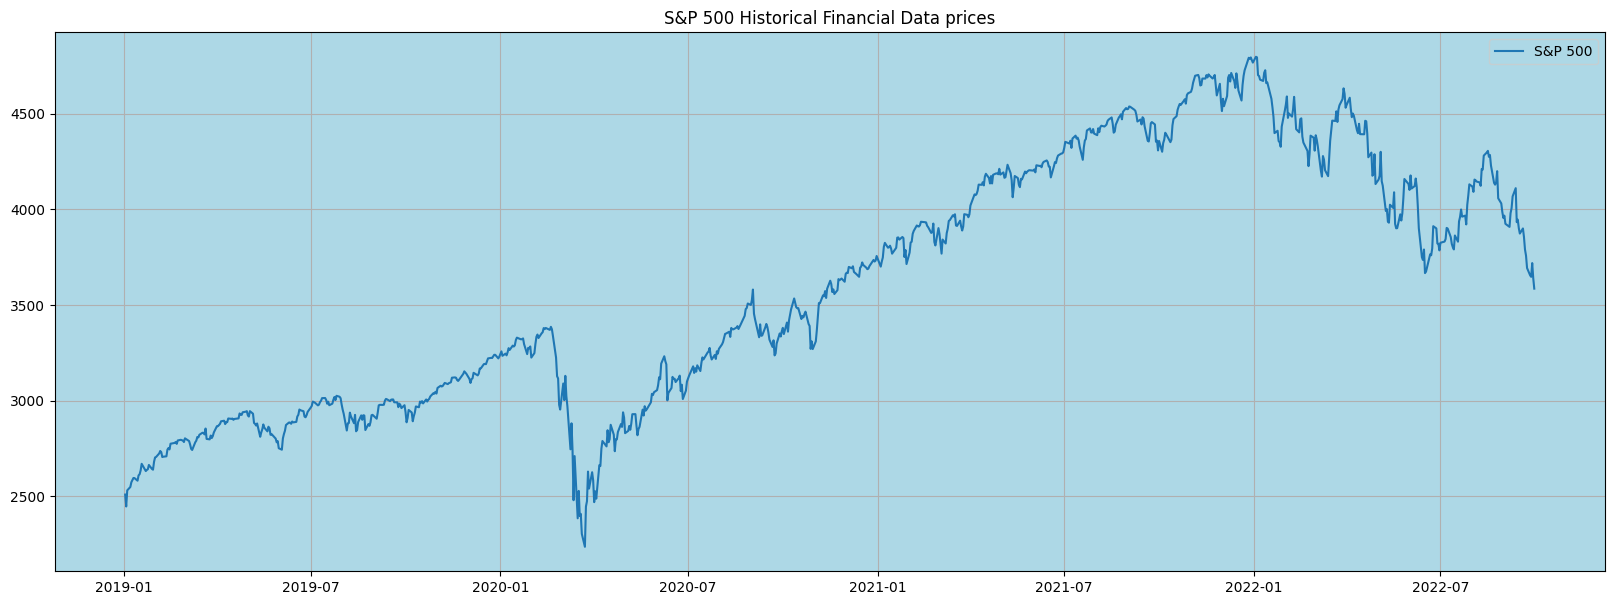

In [ ]:
### Visualising the Equity and Crypto Data
plt.figure(figsize=(20,7))
data = filtered_df['^GSPC', 'Adj Close']
plt.plot(data.index, data.values, label="S&P 500")

plt.title('S&P 500 Historical Financial Data prices')
plt.grid()
plt.legend()
plt.show()

#### Bitcoin - Cryptocurrency Data

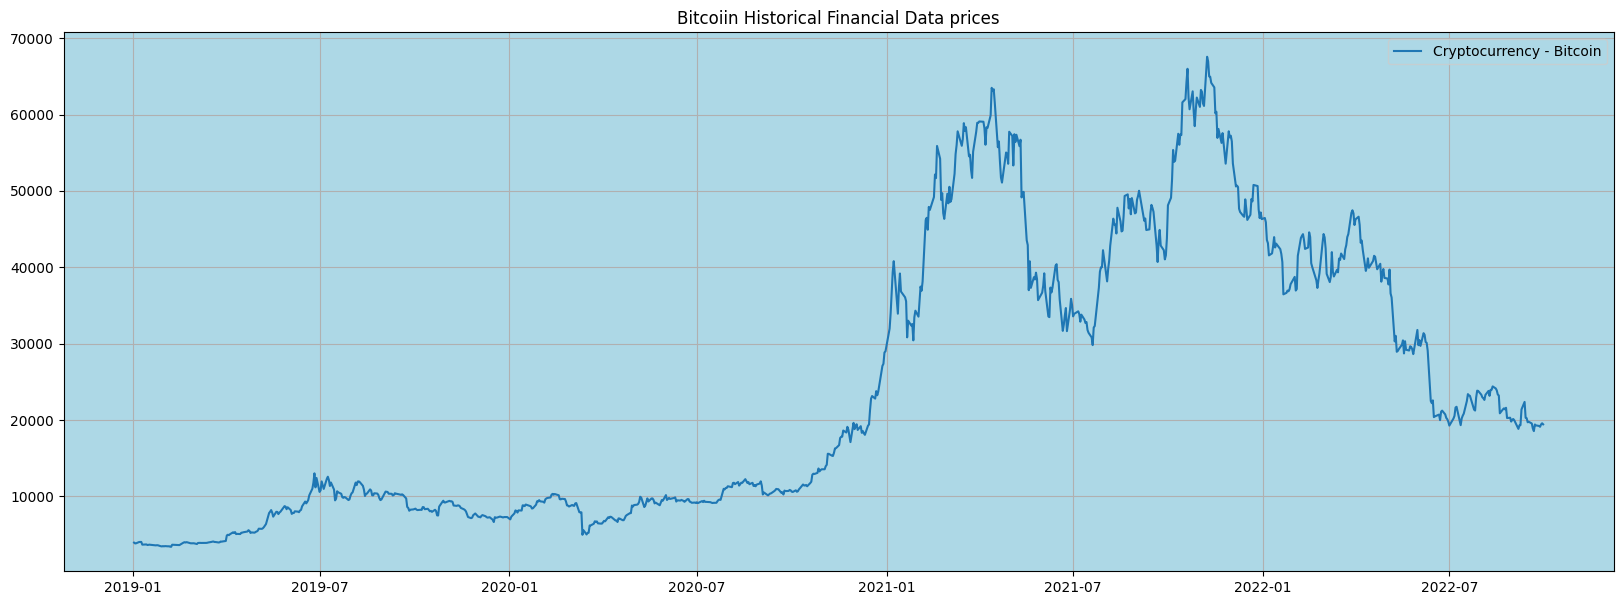

In [ ]:
### Visualising the Crypto Data
plt.figure(figsize=(20,7))
data = filtered_df['BTC-USD', 'Adj Close']
plt.plot(data.index, data.values, label="Cryptocurrency - Bitcoin")

plt.title('Bitcoiin Historical Financial Data prices')
plt.grid()
plt.legend()
plt.show()

#### Interest Rate - US Treasury Rates Data - 1-Year Treasury Constant Maturity Rate

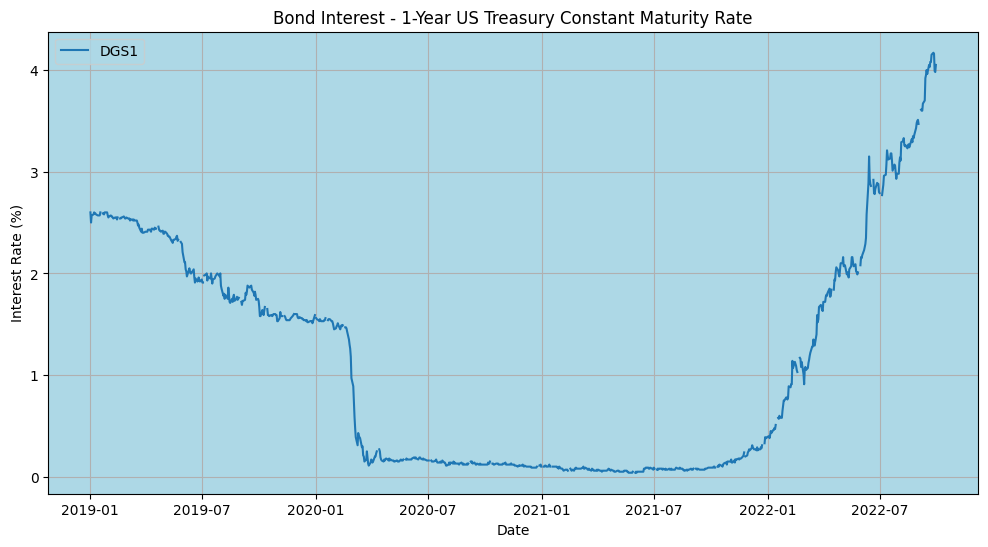

In [ ]:
# Plot the US Interest Rates Graph
plt.figure(figsize=(12, 6))
plt.plot(interest_rate_data['DGS1'])
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.title('Bond Interest - 1-Year US Treasury Constant Maturity Rate')
plt.legend(interest_rate_data.columns)
plt.grid(True)
plt.show()

#### Detecting Regime Changes/Switch

Since the data bookends the COVID pandemic, there are likely going to be several regimes in the series. The group will identify the approximate dates of the regimes, and the levels of the series.

To detect and model regime changes, we will demonstrate how to implement the Bai-Perron test

##### Bai-Perron Test:

In [ ]:
# Define the tickers and date range
tickers = ['MSFT', '^GSPC', 'BTC-USD']

# Get historical data for the tickers
data = {}

#Specifying a starting regime - low, moderate and high
regimes = 3

for ticker in tickers:
    data[ticker] = get_historical_data(ticker, start_date, end_date)

# Filter the DataFrame based on the date range
filtered_data = {}
for ticker, df in data.items():
    df.index = pd.to_datetime(df.index)
    filtered_data[ticker] = df[(df.index >= start_date) & (df.index <= end_date)].dropna()

# Perform the Bai-Perron test for regime changes
for ticker, df in filtered_data.items():
    closing_prices = df['Adj Close']
    model = markov_regression.MarkovRegression(closing_prices, k_regimes=regimes)
    results = model.fit()

    print(f"Results for {ticker} ticker:")
    print(results.summary())
    print()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Results for MSFT ticker:
                        Markov Switching Model Results                        
Dep. Variable:              Adj Close   No. Observations:                  944
Model:               MarkovRegression   Log Likelihood               -4293.645
Date:                Tue, 01 Aug 2023   AIC                           8607.290
Time:                        23:06:24   BIC                           8655.791
Sample:                             0   HQIC                          8625.776
                                - 944                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|   

###### Models interpretation

1.	**Log-likelihood:** The log-likelihood assesses a statistical model's goodness-of-fit to a given dataset. The probability function's logarithm quantifies how likely the model's parameters are to have created the observed data. Higher log-likelihood values imply that the model matches the data better.
2.	**AIC (Akaike Information Criterion):** AIC is a model selection criterion that attempts to strike a compromise between goodness-of-fit and model complexity. To avoid overfitting, it penalizes models with additional parameters. The AIC formula is as follows:
AIC = -2 * log-likelihood + 2 * number_of_parameters
AIC values with a lower AIC suggest a better match, and the model with the lowest AIC is recommended.


3.	**Bayesian Information Criterion (BIC):** BIC is a model selection criterion that is comparable to AIC but penalizes model complexity more severely. The BIC formula is:
BIC = -2 * log(number of data points) + log(number of parameters)
Lower BIC values, similar to AIC, indicate a better fit, and the model with the lowest BIC is favored.



###### **OBSERVATION:** MSFT seems to show better model fit - under a three regime model, we will select this ticker upon further confirmation.

##### CUMSUM - CUMULATIVE SUM TEST

Another statistical Test for Regime Change Detection in a dataset is the CUMSUM TEST

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Ticker: MSFT


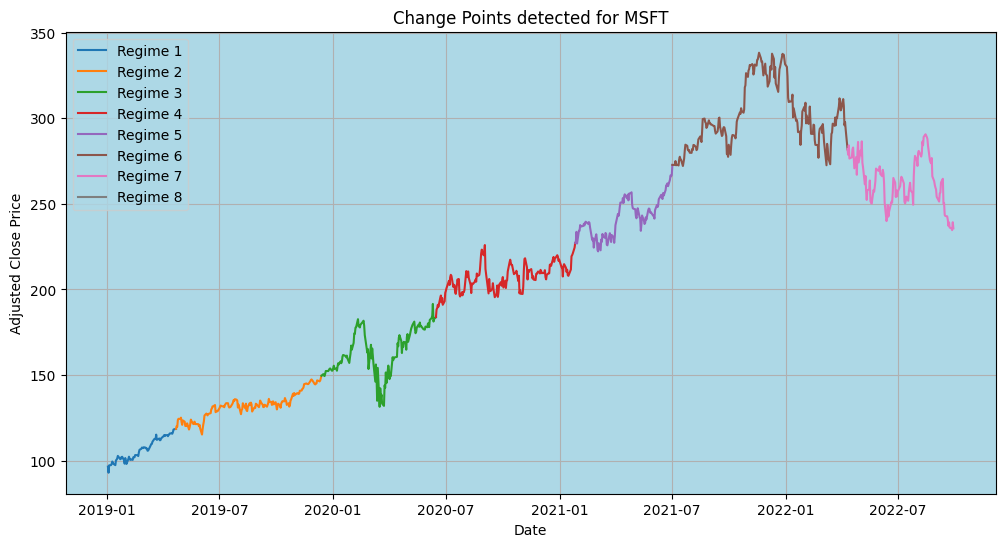

Ticker: ^GSPC


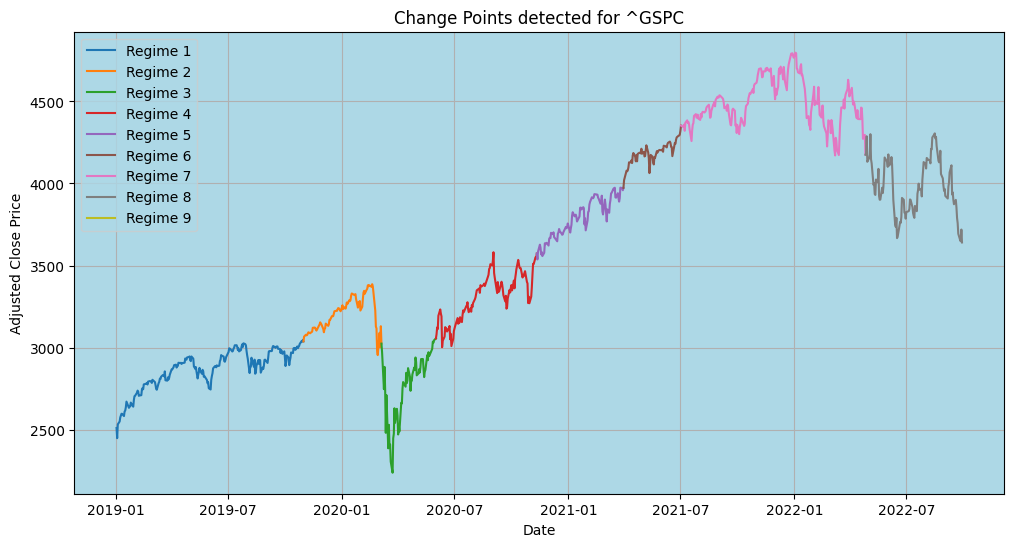

Ticker: BTC-USD


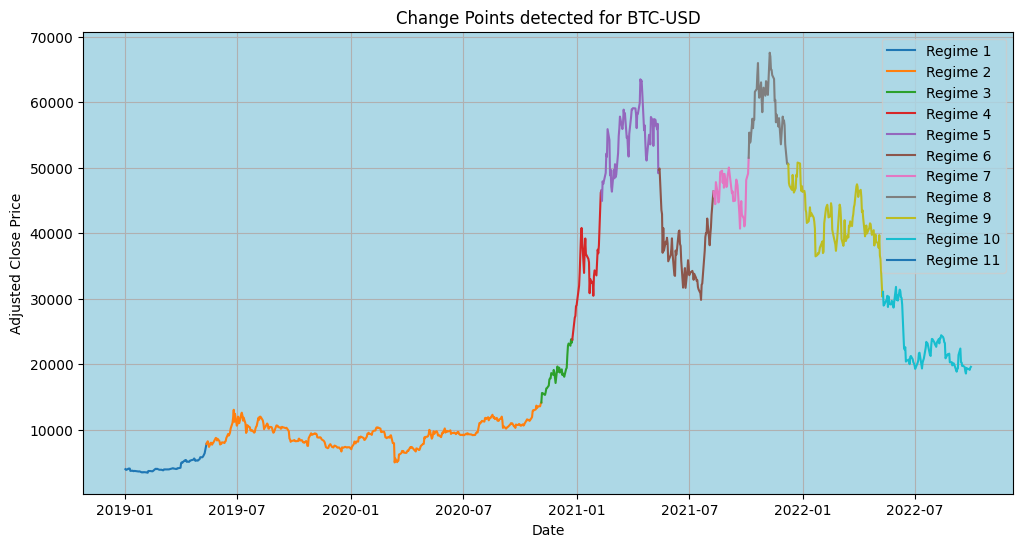

In [ ]:
# Load data for each ticker
data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start = start_date, end=end_date)['Adj Close']

# Combine data into a DataFrame
df = pd.DataFrame(data)

# Drop rows with missing values
df = df.dropna()

# Perform Pettitt test for each ticker and visualize the results
for ticker in tickers:
    print(f"Ticker: {ticker}")
    signal = df[ticker].values
    model = rpt.Pelt(model="rbf").fit(signal)
    result = model.predict(pen=10)

    # Extract and Visualizing the various Regimes and detecting dates and values change points
    change_points = [0] + list(result) + [len(signal)-1]
    periods = []
    levels = []
    for i in range(len(change_points) - 1):
        start_idx = change_points[i]
        end_idx = change_points[i+1]
        period_dates = df.index[start_idx:end_idx+1]
        period_values = df[ticker].values[start_idx:end_idx+1]
        periods.append(period_dates)
        levels.append(period_values)

    # Plot the change points with periods on the y-axis
    plt.figure(figsize=(12, 6))
    for i in range(len(periods)):
        plt.plot(periods[i], levels[i], label=f"Regime {i+1}")
    plt.title(f"Change Points detected for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.legend()
    plt.grid()
    plt.show()


##### **OBSERVATION:** Shown above are price regimes in MSFT, SP 500 and BTC(Cyrpto), indicating the various change points indicate potential regime changes in the price-time series data.

**The group then decides to model the MSFT returns as it seems to have more granular and distinct regimes.**

In [ ]:
data = yf.download('MSFT', start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [ ]:
# using .to_frame() to convert pandas series into dataframe.
msft_data = data.to_frame()

# calculating simple moving average using .rolling(window).mean() with window size = 30
msft_data['MA'] = data.rolling(30).mean()

# calculating cumulative moving
# average using .expanding().mean()
msft_data['CMA30'] = data.expanding().mean()

# calculating exponential moving average using .ewm(span).mean() , with window size = 30
msft_data['EWMA30'] = data.ewm(span=30).mean()

# Creating and plotting price returns. Price returns are just the percentage change in price over 1 day.
msft_data['Returns Daily'] = data.pct_change().dropna()

# removing all the NULL values using dropna() method
#msft_data.dropna(inplace=True)

# printing Dataframe
msft_data.head()

,Adj Close,MA,CMA30,EWMA30,Returns Daily
Date,,,,,
2019-01-02,96.421875,NaN,96.421875,96.421875,NaN
2019-01-03,92.874695,NaN,94.648285,94.589165,-0.036788
2019-01-04,97.194252,NaN,95.496941,95.516040,0.046510
2019-01-07,97.318184,NaN,95.952251,96.012596,0.001275
2019-01-08,98.023819,NaN,96.366565,96.470198,0.007251


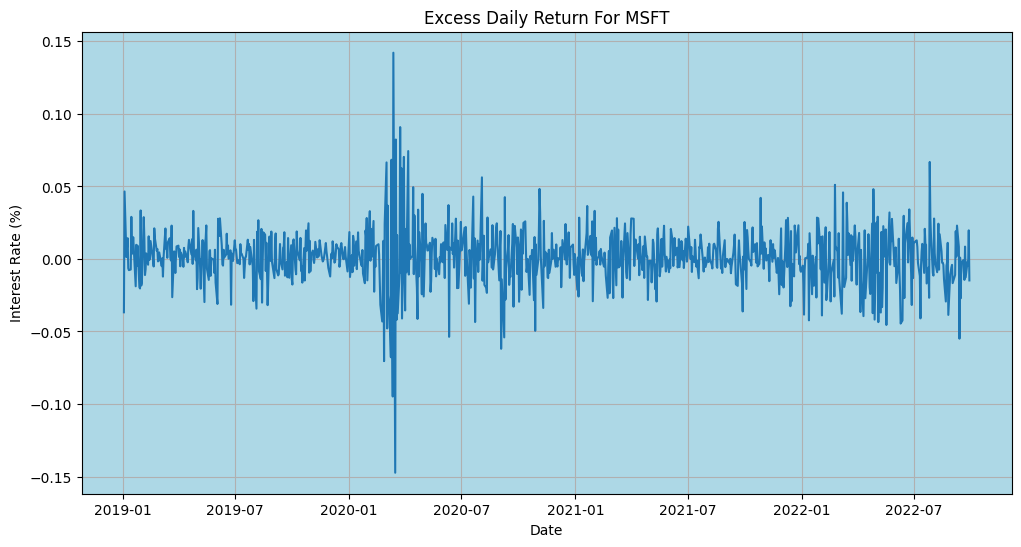

In [ ]:
# Plotting Excess Daily Returns for MSFT
plt.figure(figsize=(12, 6))
plt.plot(msft_data['Returns Daily'][1:])
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.title('Excess Daily Return For MSFT')
plt.grid(True)
plt.show()

In [ ]:
msft_data

,Adj Close,MA,CMA30,EWMA30,Returns Daily
Date,,,,,
2019-01-02,96.421875,NaN,96.421875,96.421875,NaN
2019-01-03,92.874695,NaN,94.648285,94.589165,-0.036788
2019-01-04,97.194252,NaN,95.496941,95.516040,0.046510
2019-01-07,97.318184,NaN,95.952251,96.012596,0.001275
2019-01-08,98.023819,NaN,96.366565,96.470198,0.007251
...,...,...,...,...,...
2022-09-23,236.142410,262.260473,210.709727,255.630174,-0.012698
2022-09-26,235.675919,260.479158,210.736259,254.342803,-0.001975
2022-09-27,234.643692,258.611933,210.761638,253.071893,-0.004380


Fetching Returns Data

In [ ]:
msft_returns = msft_data['Returns Daily'].dropna()

##### Model 1 - 3 Regimes on MSFT Returns

In [ ]:
regimes_number = 3

# Estimate the Markov-regime switching model with 3 regimes
model = MarkovRegression(msft_returns, k_regimes=regimes_number, switching_variance=True)
results = model.fit()

# Analyze the results and extract information about the regimes
print(results.summary())
# Step 6: Get the estimated states of the time series
estimated_states = results.smoothed_marginal_probabilities

                        Markov Switching Model Results                        
Dep. Variable:          Returns Daily   No. Observations:                  943
Model:               MarkovRegression   Log Likelihood                2554.544
Date:                Tue, 01 Aug 2023   AIC                          -5085.087
Time:                        23:07:03   BIC                          -5026.899
Sample:                             0   HQIC                         -5062.909
                                - 943                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.511      0.000       0.001       0.003
sigma2      8.024e-05   8.52e-06      9.416      0.0

##### Model 2 - 4 Regimes on MSFT Excess Daily Returns

In [ ]:
regimes_number = 4
# Estimate the Markov-regime switching model with 3 regimes
model = MarkovRegression(msft_returns, k_regimes=regimes_number, switching_variance=True)
results = model.fit()

# Analyze the results and extract information about the regimes
print(results.summary())
# Step 6: Get the estimated states of the time series
estimated_states = results.smoothed_marginal_probabilities

                        Markov Switching Model Results                        
Dep. Variable:          Returns Daily   No. Observations:                  943
Model:               MarkovRegression   Log Likelihood                2556.298
Date:                Tue, 01 Aug 2023   AIC                          -5072.596
Time:                        23:07:14   BIC                          -4975.614
Sample:                             0   HQIC                         -5035.631
                                - 943                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      4.365      0.000       0.001       0.003
sigma2      7.999e-05   8.66e-06      9.242      0.0

##### Model 3 - 5 Regimes on MSFT Excess Daily Returns

In [ ]:
regimes_number = 5
# Estimate the Markov-regime switching model with 3 regimes
model = MarkovRegression(msft_returns, k_regimes=regimes_number, switching_variance=True)
results = model.fit()

# Analyze the results and extract information about the regimes
print(results.summary())
# Step 6: Get the estimated states of the time series
estimated_states = results.smoothed_marginal_probabilities

                        Markov Switching Model Results                        
Dep. Variable:          Returns Daily   No. Observations:                  943
Model:               MarkovRegression   Log Likelihood                2563.883
Date:                Tue, 01 Aug 2023   AIC                          -5067.767
Time:                        23:07:36   BIC                          -4922.295
Sample:                             0   HQIC                         -5012.320
                                - 943                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      4.219      0.000       0.001       0.003
sigma2      8.404e-05   8.15e-06     10.311      0.0

##### **OBSERVATION: We are seeing increasing value for Log-likelihood from 3 to 5 Regimes, for purpose of result interpretability we will stop at 5 Regimes.**

In [ ]:
#Random Sampling to view Distribution
estimated_states.sample(10)

,0,1,2,3,4
Date,,,,,
2022-06-21,0.000596,0.382948,4.694402e-01,0.146873,1.426398e-04
2019-02-11,0.961235,0.010155,9.707963e-12,0.028604,5.065049e-06
2022-02-15,0.002105,0.714049,2.282068e-01,0.055561,7.850096e-05
2019-06-20,0.984957,0.005516,1.130389e-05,0.009515,7.112772e-07
2020-05-20,0.964026,0.018819,5.098717e-03,0.012053,3.662244e-06
2020-04-09,0.074716,0.576732,9.402748e-09,0.052370,2.961820e-01
2019-05-02,0.041535,0.274964,2.083571e-19,0.683459,4.200866e-05
2020-12-29,0.635194,0.325504,7.103885e-12,0.039295,7.247430e-06
2021-06-24,0.996370,0.003405,9.733804e-08,0.000225,9.792521e-08


#### Returns Variance Classfication - 5 - regimes Classfication for MSFT Excess Daily Returns

**1. Low Volatility Regime:** This regime represents periods of extremely low volatility, where the Microsoft equity prices experiences minimal price fluctuations.

**2. Moderate Volatility Regime:** In this regime, volatility increases further, and the Microsoft equity prices experiences more significant price movements.

**3. High Volatility Regime:** In this regime, the market experiences substantial price fluctuations and heightened volatility.

**4. Very High Volatility Regime:** This regime signifies very high levels of volatility, where extreme price movements and market turbulence are prevalent.

**5. Extreme Volatility Regime:** This is the highest volatility regime, representing periods of extreme market instability and unpredictable price movements.

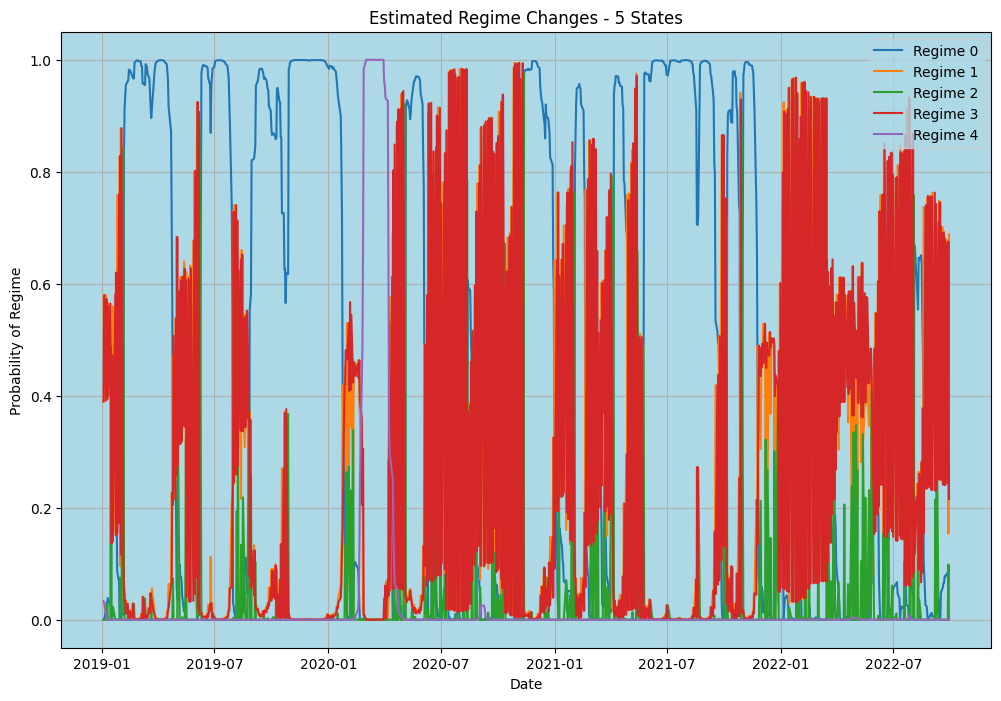

In [ ]:
# Plot the estimated states over time
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.plot(estimated_states.index, estimated_states[i], label=f'Regime {i}')

plt.xlabel('Date')
plt.ylabel('Probability of Regime')
plt.title('Estimated Regime Changes - 5 States')
plt.legend()
plt.grid(True)
plt.show()

#### Breaking Down the Various Returns Regimes over the MSFT Time Series

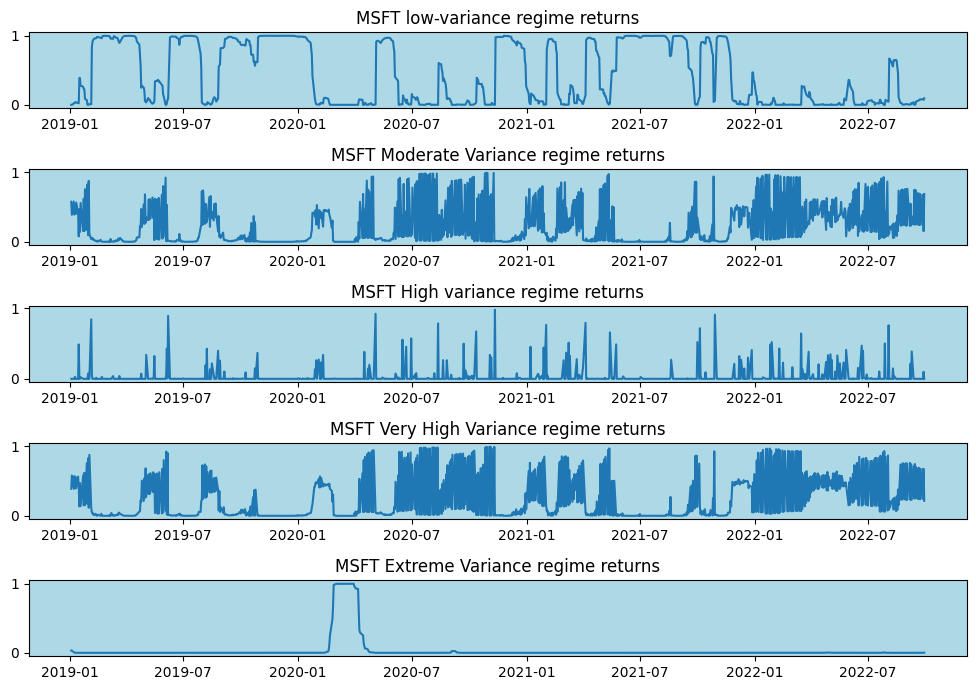

In [ ]:
regimes = ['low-variance', 'Moderate Variance', 'High variance', 'Very High Variance', 'Extreme Variance']

fig, axes = plt.subplots(5, figsize=(10,7))

for i in range(0,len(regimes)):
  ax = axes[i]
  ax.plot(estimated_states[i])
  ax.grid(False)
  title = 'MSFT '+regimes[i]+' regime returns'
  ax.set(title=title)

# Add spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### i) Different number of Regime states

In [ ]:
# Define the tickers and date range
tickers = ['MSFT']

# Get historical data for the tickers
data = {}
for ticker in tickers:
    data[ticker] = get_historical_data(ticker, start_date, end_date)

# Filter the DataFrame based on the date range
filtered_data = {}
for ticker, df in data.items():
    df.index = pd.to_datetime(df.index)
    filtered_data[ticker] = df[(df.index >= start_date) & (df.index <= end_date)].dropna()

[*********************100%***********************]  1 of 1 completed


Results Dataframe

In [ ]:
# Create a dataframe to save all results
results_df = pd.DataFrame(columns = ['Regimes', 'Assumptions','Log-Likelihood', 'AIC', 'BIC'])

In [ ]:
assumption = 'Different number of states'

# Perform the Bai-Perron test for regime states
model_output = {}
start_regime_states = 2
end_regime_states = 5

for ticker, df in filtered_data.items():
    for k in range(start_regime_states,end_regime_states+1):
      daily_returns = df['Adj Close'].pct_change().dropna()
      model = markov_regression.MarkovRegression(daily_returns, k_regimes=k)
      results = model.fit()

      # Save data
      results_df.loc[len(results_df)] = [k,assumption,results.llf, results.aic, results.bic]
      #model_output[k] = [results.llf, results.aic, results.bic]
      #print(model_output)
#print(model_output)


In [ ]:
results_df

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
0,2,Different number of states,2376.146131,-4742.292262,-4718.046930
1,3,Different number of states,2377.572164,-4735.144329,-4686.653666
2,4,Different number of states,2463.827261,-4893.654523,-4811.220396
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134


**OBSERVATION:** We are able to observe a better model parameters with 5 regimes state.

In [ ]:
# Step 1: Load financial time series data using yfinance
data = yf.download('MSFT', start='2019-01-01', end='2022-09-30')['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### ii) Allowing the expected realization of the time series to differ across states
- different “mus”  but constant variance (i.e, same “sigma”).

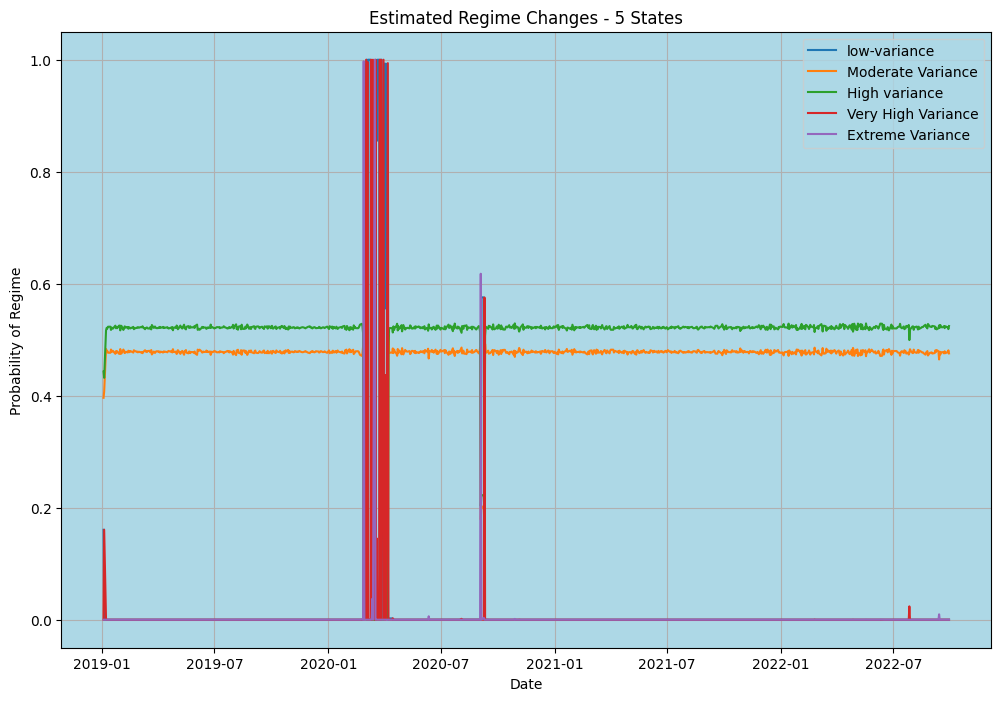

In [ ]:
assumption = 'different mus same variance'
regimes_number = 5
# Step 3: Estimate the Markov-regime switching model with 5 regimes and different "mus" same variance
model = MarkovRegression(data, k_regimes=regimes_number, switching_variance=False, switching_trend=True)

# Step 4: Fit the model to the data
results = model.fit()

# Save Data
#print(results.summary())
# Save data
results_df.loc[len(results_df)] = [regimes_number,assumption,results.llf, results.aic, results.bic]

# Step 6: Get the estimated states of the time series
estimated_states = results.smoothed_marginal_probabilities

# Step 7: Plot the estimated states over time
plt.figure(figsize=(12, 8))
for i in range(regimes_number):
  plt.plot(data.index, estimated_states[i], label=regimes[i])

plt.xlabel('Date')
plt.ylabel('Probability of Regime')
plt.title('Estimated Regime Changes - 5 States')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
results_df

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
0,2,Different number of states,2376.146131,-4742.292262,-4718.046930
1,3,Different number of states,2377.572164,-4735.144329,-4686.653666
2,4,Different number of states,2463.827261,-4893.654523,-4811.220396
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134
4,5,different mus same variance,2474.900862,-4897.801725,-4771.726001


##### **OBSERVATION:**  From the Chart above, the impact of the Covid-Lockdown created a period of high return volatility for MSFT Stocks - this is consistent with news data about the impact of Covid-19 on the Stock Market at the time. While Extreme volatility was less prevalent, the period of Low to Moderate return volatility accounts for the general overview of the MSFT stock's return in the period under review.

### iii) Allowing the variance of the time series to change across states
- (different “sigmas”), but with constant expectation (same “mu”).

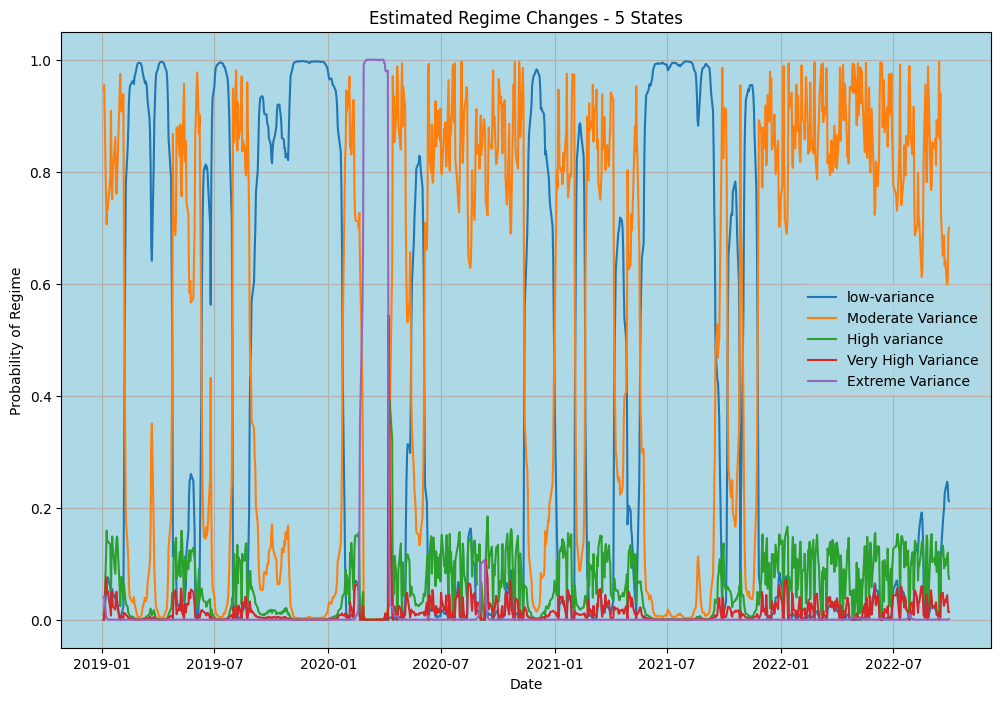

In [ ]:
assumption = 'different sigmas same mus'
regimes_number = 5

model = MarkovRegression(data, k_regimes=regimes_number, switching_variance=True, switching_trend=False)
results = model.fit()

# Save Data
#print(results.summary())
# Save data
results_df.loc[len(results_df)] = [regimes_number,assumption,results.llf, results.aic, results.bic]

# Step 6: Get the estimated states of the time series
estimated_states = results.smoothed_marginal_probabilities

# Step 7: Plot the estimated states over time
plt.figure(figsize=(12, 8))
for i in range(regimes_number):
  plt.plot(data.index, estimated_states[i], label=regimes[i])

plt.xlabel('Date')
plt.ylabel('Probability of Regime')
plt.title('Estimated Regime Changes - 5 States')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
results_df

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
0,2,Different number of states,2376.146131,-4742.292262,-4718.046930
1,3,Different number of states,2377.572164,-4735.144329,-4686.653666
2,4,Different number of states,2463.827261,-4893.654523,-4811.220396
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134
4,5,different mus same variance,2474.900862,-4897.801725,-4771.726001
5,5,different sigmas same mus,2553.631094,-5055.262188,-4929.186465


##### **OBSERVATION:** Allowing the variance of the time series to change across states seems to have given prevalence to the Moderate and Low returns periods.

### iv) Allowing for different expectations and variances across states.

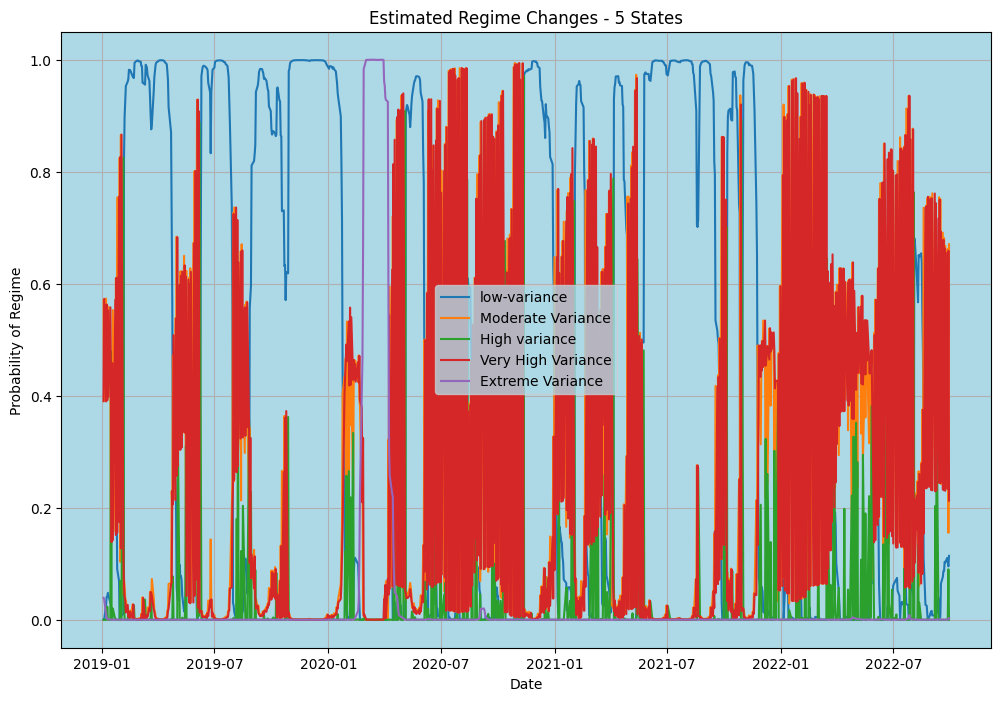

In [ ]:
assumption = 'different sigmas and mus'
regimes_number = 5

model = MarkovRegression(data, k_regimes=regimes_number, switching_variance=True, switching_trend=True)
results = model.fit()

# Save Data
#print(results.summary())
# Save data
results_df.loc[len(results_df)] = [regimes_number,assumption,results.llf, results.aic, results.bic]

# Step 6: Get the estimated states of the time series
estimated_states = results.smoothed_marginal_probabilities

# Step 7: Plot the estimated states over time
plt.figure(figsize=(12, 8))
for i in range(regimes_number):
  plt.plot(data.index, estimated_states[i], label=regimes[i])

plt.xlabel('Date')
plt.ylabel('Probability of Regime')
plt.title('Estimated Regime Changes - 5 States')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
results_df

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
0,2,Different number of states,2376.146131,-4742.292262,-4718.046930
1,3,Different number of states,2377.572164,-4735.144329,-4686.653666
2,4,Different number of states,2463.827261,-4893.654523,-4811.220396
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134
4,5,different mus same variance,2474.900862,-4897.801725,-4771.726001
5,5,different sigmas same mus,2553.631094,-5055.262188,-4929.186465
6,5,different sigmas and mus,2563.347804,-5066.695608,-4921.223620


##### **OBSERVATION:** Allowing for different expectations and variances across states seems to have given prevalence to the very high variance returns periods. Model fits seems to be better.

## Step 3 - Performance Comparison

### a. Comparing the models with different mu values.

In [ ]:
results_df.iloc[[3,4]]

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134
4,5,different mus same variance,2474.900862,-4897.801725,-4771.726001


**OBSERVATION:** The Log-likelihood improved slightly with the different mus from the default state, this shows that allowing for different mus in the regime model - we are able to record a better model fit. The AIC and BIC also improved as well, as they are lower in the model with the different mus.

### b. Comparing models with different sigma values.


In [ ]:
results_df.iloc[[3,5]]

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134
5,5,different sigmas same mus,2553.631094,-5055.262188,-4929.186465


**OBSERVATION:** The Log-likelihood improved **significantly** with the different sigmas from the default state, this shows that allowing for different mus in the regime model - we are able to record a better model fit. The AIC and BIC also improved as well, as they are lower in the model with the different sigmas.

### c. Comparing the models with different expectations and variances.


In [ ]:
results_df.iloc[[3,6]]

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134
6,5,different sigmas and mus,2563.347804,-5066.695608,-4921.223620


**OBSERVATION:** The Log-likelihood improved **significantly** with the different sigmas and mus compared to the default state, this shows that allowing for different mus in the regime model - we are able to record a better model fit. AIC and BIC also improved as well, as they are much lower in the model.

### d. Models ranking

Using Log-Likelihood to Sort the Models according to the goodness of fit.

In [ ]:
results_df.iloc[[3,4,5,6]].sort_values(by='Log-Likelihood', ascending=False)

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
6,5,different sigmas and mus,2563.347804,-5066.695608,-4921.223620
5,5,different sigmas same mus,2553.631094,-5055.262188,-4929.186465
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134
4,5,different mus same variance,2474.900862,-4897.801725,-4771.726001


**OBSERVATION:** The model with the different sigmas and mus best captures the underlying dynamics better than all other model assumptions.

### Result Interpretations

Allowing the expected realization of the returns times series to vary across states, as well as various variances (standard deviations) for each state, had a substantial impact on how the model captured changes in the underlying data-generating process.

1. Different Expected Realizations (Different "Mus"):
Different "mus" in a Markov regime-switching model relate to different mean values for the time series in each state. Each stage indicates a distinct regime or concealed state of the underlying process. Allowing for different "mus" means that the mean of the time series can shift when changing regimes.
Implications:
   - Capturing Regime-Specific Behavior: By allowing for distinct "mus," the model is able to capture regime-specific behavior in the time series. Each state reflects a unique market circumstance, economic climate, or behavioral trend, and several "mus" let the model to adjust to these changes.
   - Improved Fit for Non-Stationary Data: If the time series data display non-stationary behavior, alternative "mus" can help capture these fluctuations, resulting in a better model-data fit.
   - Increased Model Complexity: Allowing for different "mus" increases the amount of parameters in the model, making it more complex and potentially introducing overfitting.

2. Different Variances (Different "Sigmas"):
Various "sigmas" in a Markov regime-switching model refer to different standard deviations for the time series in each state. Each state may be associated with a distinct level of volatility, uncertainty, or variability.

Implications:
   - Capturing Regime-Specific Volatility: The model can reflect different amounts of volatility in each regime by allowing for variable "sigmas." Some states may be more volatile than others, while others may be very steady or low in volatility.
   - Enhanced Representation of Heteroscedasticity: If the time series data show heteroscedasticity (changing levels of volatility over time), different "sigmas" can be used to model this attribute more accurately than assuming constant variance throughout.
   - Improved Risk Management:  Different "sigmas" can aid in more successfully predicting risk, particularly in circumstances where volatility changes significantly across market conditions.
   - Increased Model Complexity: As with permitting multiple "mus," introducing different "sigmas" enhances the model's complexity, necessitating careful parameter estimate and model selection.

Thus, in a regime change Markov model, allowing the anticipated realization ("mus") and variance ("sigmas") of the time series to shift between states offers flexibility and adaptability to represent regime-specific behavior and altering volatility. It does, however, come at the expense of increasing model complexity, which must be carefully handled in order to avoid overfitting and ensure the model's generalization to new data.


## Step 4 - Collaboration

In this case, we're employing an AR model whose current value is expressed as a linear combination of its previous values, sometimes known as "lags." The model posits that the time series' future values are linearly related to its own previous values, and the order of the AR model, represented by "p," represents the number of lag factors considered in the model.
Mathematical representation of an AR(p) model is as follows:

$$ X_{t} = C + \alpha_{t} X_{t-1} + W_{t} $$

$$y_{t} = c + φ_{1}y_{t-1} + φ_{2}y_{t-2} + ... + φ_{p}y_{t-p} + ε_{t}$$

Where:

- $y_{t}$ - represents the value of the time series at time "t."
•	c is the intercept or constant term.
•	$φ_{1}$, $φ_{2}$, ..., $φ_{p}$ are the autoregressive coefficients, which determine the impact of the past values on the current value. These coefficients are typically estimated from the data.
•	$y_{t-1}$, $y_{t-2}$, ..., $y_{t-p}$ are the lagged values of the time series.
•	$ε_{t}$ is the error term, representing the random noise or unpredicted component of the time series at time "t."


**Task Procedure:** Here we will define the regime change model with 5 regimes the model assumes that the coefficient changes depending on the state (regime). We will estimate a five-regime model with different autoregressive coefficients. We will also estimate heteroskedasticity (variance change) in the error term.

In [ ]:
assumption = 'AR process whose AR coefficient changes'

msft_returns = pd.DataFrame(msft_data['Returns Daily'].dropna())
msft_returns.index = pd.to_datetime(msft_returns.index)

# Create lagged returns for autoregressive model
lags = 1
for i in range(1, lags + 1):
    msft_returns[f'Lag_{i}'] = msft_returns.shift(i)

# Set up the endogenous variable (y) and exogenous variables (X)
y = msft_data['Adj Close'][1:]
X = sm.add_constant(msft_returns[['Lag_1'][1:]])

# Create the feature variables for the 5 regimes
var_1 = pd.Series(np.where((msft_returns.index >= datetime.strptime('2020-01-01',"%Y-%m-%d")),1, 0), index=msft_returns.index, name=regimes[0])
var_2 = pd.Series(np.where((msft_returns.index >= datetime.strptime('2019-04-01',"%Y-%m-%d")) & (msft_returns.index < datetime.strptime('2020-01-01',"%Y-%m-%d")), 1, 0), index=msft_returns.index, name=regimes[1])
var_3 = pd.Series(np.where((msft_returns.index >= datetime.strptime('2019-01-01',"%Y-%m-%d")) & (msft_returns.index < datetime.strptime('2019-04-01',"%Y-%m-%d")), 1, 0), index=msft_returns.index, name=regimes[2])
var_4 = pd.Series(np.where((msft_returns.index >= datetime.strptime('2021-01-01',"%Y-%m-%d")) & (msft_returns.index < datetime.strptime('2022-01-01',"%Y-%m-%d")), 1, 0), index=msft_returns.index, name=regimes[3])
var_5 = pd.Series(np.where((msft_returns.index >= datetime.strptime('2022-01-01',"%Y-%m-%d")) & (msft_returns.index < datetime.strptime('2022-10-01',"%Y-%m-%d")), 1, 0), index=msft_returns.index, name=regimes[4])

# Concatenate the dummy variables with X
X = pd.concat([X, var_1, var_2, var_3, var_4, var_5], axis=1)

# Estimate the regime change model
model = sm.OLS(y, X)
results = model.fit()

# Save data
results_df.loc[len(results_df)] = [regimes_number,assumption,results.llf, results.aic, results.bic]

# Print the summary of the estimation
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1508.
Date:                Tue, 01 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:09:18   Log-Likelihood:                -4362.7
No. Observations:                 943   AIC:                             8735.
Df Residuals:                     938   BIC:                             8760.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.477e+14   2.38

In [ ]:
results_df

,Regimes,Assumptions,Log-Likelihood,AIC,BIC
0,2,Different number of states,2376.146131,-4742.292262,-4718.046930
1,3,Different number of states,2377.572164,-4735.144329,-4686.653666
2,4,Different number of states,2463.827261,-4893.654523,-4811.220396
3,5,Different number of states,2487.247429,-4922.494858,-4796.419134
4,5,different mus same variance,2474.900862,-4897.801725,-4771.726001
5,5,different sigmas same mus,2553.631094,-5055.262188,-4929.186465
6,5,different sigmas and mus,2563.347804,-5066.695608,-4921.223620
7,5,AR process whose AR coefficient changes,-4362.705530,8735.411059,8759.656391


**OBSERVATION:** Introducing an AR Process into the Regime Change did not improve the model Performance around the data, in fact - it seems to have performed worst among all the model design for Returns regime for MSFT.

##  Conclusion

Understanding the various underlying asset regime changes can assist in making an informed analyst, usually the regime changes can be period specific or influenced by certain natural occurence such as the Covid-19 of year 2020 which ultimately distorted typical dynamics of financial securities all over the world. In this report, we demonstrated varying fit scenarios for financial dataset from 2019-01-01 to 2022-09-30 and showed adjusting the Markov model parameters can result in better fits results.

## References

- Awad, Mariette, and Rahul Khanna. “Hidden Markov Model.” Efficient Learning Machines: Theories, Concepts, and Applications for Engineers and System Designers, edited by Mariette Awad and Rahul Khanna, Apress, 2015, pp. 81–104. Springer Link, https://doi.org/10.1007/978-1-4302-5990-9_5.

- Chen, Ying, and Vladimir Spokoiny. “Modeling Nonstationary and Leptokurtic Financial Time Series.” Econometric Theory, vol. 31, no. 4, 2015, pp. 703–28.

- Eric. “Introduction to Markov-Switching Models.” Aptech, 3 Sept. 2021, https://www.aptech.com/blog/introduction-to-markov-switching-models/.

- James D. Hamilton(1994). Time Series Analysis. Princeton University Press.

- Mendy, David & Widodo, Tri. (2018). Do Education Levels Matter on Indonesian Economic Growth?. Economics & Sociology. 11. 133-146. 10.14254/2071-789X.2018/11-3/8.

- WQU - WorldQuant University (2023) Stochastic Modeling, Module 4. Lessons 1 - 4.

- WQU - WorldQuant University (2023) Econometrics, Module 4.Lessons 1 - 4.

Appendix